In [64]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from torchvision.models import vit_b_16, ViT_B_16_Weights
import matplotlib.pyplot as plt

In [65]:
# Constants
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
IMAGE_SIZE = 224  # ViT expects 224x224 images

# Load and preprocess data
data = np.load('snipe_data_rgb_full_cropped.npz')['arr_0']
print(f"Data shape after loading: {data.shape}")

# filter out people with too few photos
# there are probably better ways of doing this, but this works
# allyn = 1, evelyn = 5, katie = 8, kiana = 9
# mike = 11, nathan = 13, reilly = 15, spencer = 16
num_classes = 8
label_names = ['Allyn','Evelyn','Katie','Kiana','Mike','Nathan','Reilly','Spencer']
data = data[np.isin(data[:, 0], (1, 5, 8, 9, 11, 13, 15, 16))]
label_map = {1:0, 5:1, 8:2, 9:3, 11:4, 13:5, 15:6, 16:7}
for i in range(data.shape[0]):
    data[i][0] = label_map[data[i][0]]
print(f"Data shape after filtering: {data.shape}")
print(f"Labels after filtering: {np.unique(data[:,0])}")

labels = data[:, 0].astype(np.int64)

# Calculate expected pixels per image
pixels_per_image = 3 * IMAGE_HEIGHT * IMAGE_WIDTH  # 147,456
print(f"Pixels per image: {pixels_per_image}")

# Calculate total features per sample
total_features_per_sample = data.shape[1] - 1  # Excluding the label
print(f"Total features per sample (excluding label): {total_features_per_sample}")

# Determine number of additional features
num_additional_features = total_features_per_sample - pixels_per_image
print(f"Number of additional features: {num_additional_features}")

if num_additional_features < 0:
    raise ValueError("Total features per sample is less than the expected number of pixels per image.")

# Adjust indexing based on where the image data is located
# Assuming additional features are before the image data
image_data = data[:, 1 + num_additional_features:].astype(np.uint8)

print("Image data shape:", image_data.shape)  # Should be (num_images, 3, 256, 192)
print("Data type:", image_data.dtype)  # Should be np.uint8 if it's raw pixel data in [0, 255]
print("Min pixel value:", image_data.min(), "Max pixel value:", image_data.max())  # Check for [0, 255] range



# (Optional) Extract additional features if needed
additional_features = data[:, 1:1 + num_additional_features]
print(f"Additional features shape: {additional_features.shape}")

# Reshape image data to (num_samples, 3, H, W)
image_data = image_data.reshape(-1, IMAGE_HEIGHT, IMAGE_WIDTH, 3)
print(f"Image data shape after reshaping: {image_data.shape}")

# Proceed with data splitting
X_train, X_test, y_train, y_test = train_test_split(
    image_data, labels, test_size=0.2, random_state=42, stratify=labels
)


Data shape after loading: (4246, 196616)
Data shape after filtering: (2848, 196616)
Labels after filtering: [0 1 2 3 4 5 6 7]
Pixels per image: 196608
Total features per sample (excluding label): 196615
Number of additional features: 7
Image data shape: (2848, 196608)
Data type: uint8
Min pixel value: 0 Max pixel value: 255
Additional features shape: (2848, 7)
Image data shape after reshaping: (2848, 256, 256, 3)


In [66]:
class ImageDataset(Dataset):
    def __init__(self, features, targets, transform=None):
        self.features = features
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        # Get the image and label in HWC format
        image = self.features[index].astype(np.uint8)  # Shape: (H, W, C)
        label = self.targets[index]

        if self.transform:
            # Apply transformation, which now assumes image in HWC format
            image = self.transform(image)
        return image, label


In [67]:

# Data transformations
transform_train = transforms.Compose([
    transforms.ToPILImage(),  # Convert from HWC to PIL image
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),  # Converts to CHW format and scales to [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [68]:
# Create Datasets and DataLoaders
train_dataset = ImageDataset(X_train, y_train, transform=transform_train)
test_dataset = ImageDataset(X_test, y_test, transform=transform_test)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

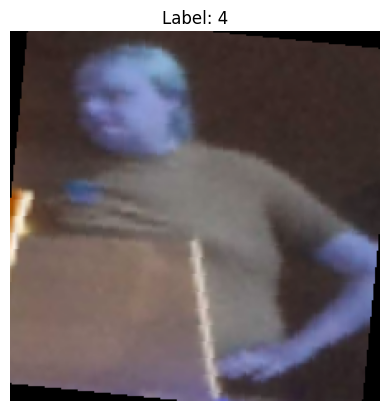

In [69]:
# Get a sample from the training dataset
sample_image, sample_label = train_dataset[1000]

# Undo the normalization for visualization
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
sample_image = sample_image * std + mean  # Denormalize
sample_image = sample_image.clamp(0, 1)   # Ensure values are between 0 and 1

# Convert to numpy and transpose for plotting
sample_image_np = sample_image.numpy().transpose((1, 2, 0))  # CHW to HWC

plt.imshow(sample_image_np)
plt.title(f"Label: {sample_label}")
plt.axis('off')
plt.show()


In [70]:
# Load pre-trained ViT model
vit = vit_b_16(weights=ViT_B_16_Weights.DEFAULT)

# Modify the classifier head
num_ftrs = vit.heads.head.in_features
vit.heads.head = nn.Linear(num_ftrs, num_classes)

# Move the model to device
vit = vit.to(device)

In [71]:
# test saving
torch.save(vit.state_dict(), "pretrained_vit.pt")

In [72]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit.parameters(), lr=0.0001)

In [73]:
# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    best_accuracy = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (preds == labels).sum().item()

        val_accuracy = 100 * val_correct / val_total
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Loss: {running_loss/len(train_loader):.4f}, '
              f'Validation Accuracy: {val_accuracy:.2f}%')

        # Save the best model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')

    print(f'Best Validation Accuracy: {best_accuracy:.2f}%')

In [74]:
# Evaluation function with confusion matrix
def evaluate_model(model, test_loader, num_classes):
    model.eval()
    test_correct = 0
    test_total = 0

    # Set up confusion matrix
    predictions = np.zeros((num_classes, num_classes), dtype=np.float64)

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (preds == labels).sum().item()

            # Store data in confusion matrix
            for l, p in zip(labels, preds):
                predictions[l][p] += 1 

    # Normalize confusion matrix
    for label in range(num_classes):
        predictions[label] /= np.sum(predictions[label])

    test_accuracy = 100 * test_correct / test_total
    print(f'Test Accuracy: {test_accuracy:.2f}%')
    
    return predictions


In [75]:
# Function to plot confusion matrix
def plot_confusion_matrix(arr, labels):
    fig, ax = plt.subplots()
    im = ax.imshow(arr)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    ax.set_title("Normalized Actual vs. Predicted Snipes")
    fig.colorbar(im, ax=ax)
    fig.tight_layout()
    plt.show()


In [76]:
# Step 1: Freeze all transformer layers except the classifier head
for param in vit.parameters():
    param.requires_grad = False
for param in vit.heads.parameters():  # Assuming 'heads' is the classifier layer
    param.requires_grad = True

# Set up the optimizer for training the classifier head only
optimizer = optim.Adam(filter(lambda p: p.requires_grad, vit.parameters()), lr=1e-4)

# Train the model with the initial setup
train_model(vit, train_loader, test_loader, criterion, optimizer, num_epochs=20)
torch.save(vit.state_dict(), "training_stage_one.pth")

Epoch [1/20], Loss: 2.0850, Validation Accuracy: 21.05%
Epoch [2/20], Loss: 1.9645, Validation Accuracy: 27.02%
Epoch [3/20], Loss: 1.8697, Validation Accuracy: 28.25%
Epoch [4/20], Loss: 1.7988, Validation Accuracy: 32.98%
Epoch [5/20], Loss: 1.7357, Validation Accuracy: 35.79%
Epoch [6/20], Loss: 1.6777, Validation Accuracy: 38.25%
Epoch [7/20], Loss: 1.6291, Validation Accuracy: 39.47%
Epoch [8/20], Loss: 1.5842, Validation Accuracy: 41.05%
Epoch [9/20], Loss: 1.5362, Validation Accuracy: 41.93%
Epoch [10/20], Loss: 1.5130, Validation Accuracy: 43.68%
Epoch [11/20], Loss: 1.4762, Validation Accuracy: 44.74%
Epoch [12/20], Loss: 1.4428, Validation Accuracy: 45.61%
Epoch [13/20], Loss: 1.4100, Validation Accuracy: 46.14%
Epoch [14/20], Loss: 1.3914, Validation Accuracy: 46.32%
Epoch [15/20], Loss: 1.3598, Validation Accuracy: 47.72%
Epoch [16/20], Loss: 1.3356, Validation Accuracy: 47.02%
Epoch [17/20], Loss: 1.3156, Validation Accuracy: 48.07%
Epoch [18/20], Loss: 1.2873, Validation 

Test Accuracy: 50.00%


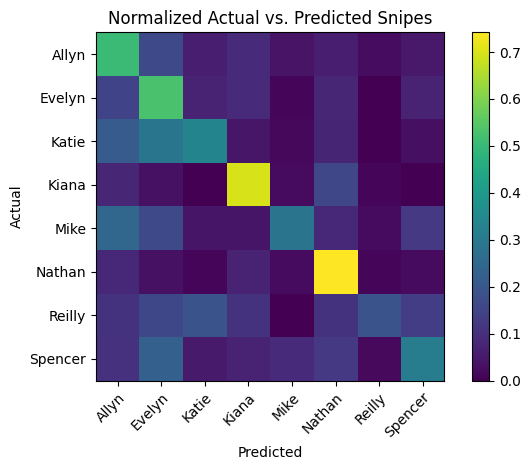

In [77]:
# Assuming your model and test_loader are defined, evaluate and plot
# num_classes = 19  # Update to your number of classes
confusion_matrix = evaluate_model(vit, test_loader, num_classes)

# Assuming label names are in a CSV file
# label_names = pd.read_csv('labels.csv', header=None).values.flatten()
plot_confusion_matrix(confusion_matrix, label_names)

In [78]:
# Step 3: Unfreeze the last few transformer layers for fine-tuning
for param in vit.encoder.layers[-4:].parameters():  # Adjust based on ViT model structure
    param.requires_grad = True

# Adjust optimizer with a lower learning rate for fine-tuning
optimizer = optim.Adam(filter(lambda p: p.requires_grad, vit.parameters()), lr=1e-5)

# Continue training with fine-tuning on the last few transformer layers
train_model(vit, train_loader, test_loader, criterion, optimizer, num_epochs=10)
torch.save(vit.state_dict(), "training_stage_two.pth")

Epoch [1/20], Loss: 1.1577, Validation Accuracy: 57.19%
Epoch [2/20], Loss: 0.9525, Validation Accuracy: 63.68%
Epoch [3/20], Loss: 0.7943, Validation Accuracy: 66.84%
Epoch [4/20], Loss: 0.6617, Validation Accuracy: 68.25%
Epoch [5/20], Loss: 0.5516, Validation Accuracy: 70.88%
Epoch [6/20], Loss: 0.4626, Validation Accuracy: 73.51%
Epoch [7/20], Loss: 0.3851, Validation Accuracy: 73.33%


Test Accuracy: 29.70%


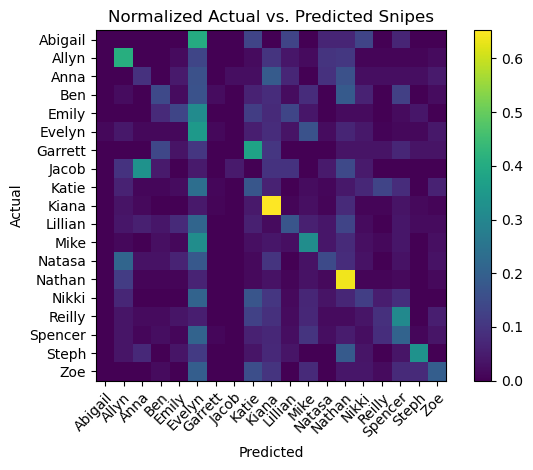

In [ ]:
# Evaluate fine-tuning performance
confusion_matrix = evaluate_model(vit, test_loader, num_classes)
plot_confusion_matrix(confusion_matrix, label_names)


In [ ]:
# Step 5: Unfreeze all layers for complete fine-tuning
for param in vit.parameters():
    param.requires_grad = True

# Use an even lower learning rate for all layers
optimizer = optim.Adam(vit.parameters(), lr=1e-6)

# Train with all layers unfreezed
train_model(vit, train_loader, test_loader, criterion, optimizer, num_epochs=5)
torch.save(vit.state_dict(), "best_model.pth")

Epoch [1/5], Loss: 1.2642, Validation Accuracy: 29.86%
Epoch [2/5], Loss: 1.2285, Validation Accuracy: 29.70%
Epoch [3/5], Loss: 1.2111, Validation Accuracy: 29.22%
Epoch [4/5], Loss: 1.1863, Validation Accuracy: 29.78%
Epoch [5/5], Loss: 1.1745, Validation Accuracy: 29.62%
Best Validation Accuracy: 29.86%


Test Accuracy: 29.62%


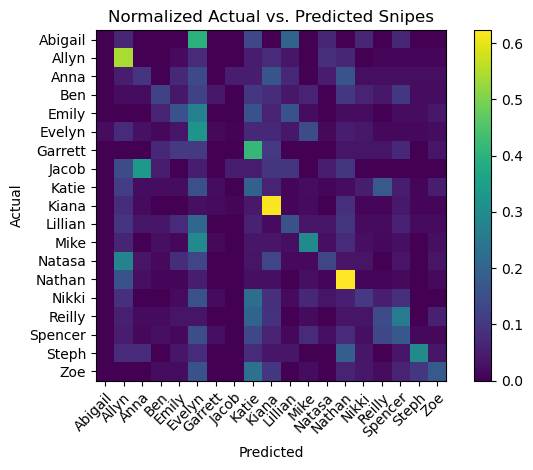

In [ ]:
# Evaluate fine-tuning performance
confusion_matrix = evaluate_model(vit, test_loader, num_classes)
plot_confusion_matrix(confusion_matrix, label_names)


In [ ]:
# Load the best model weights
vit.load_state_dict(torch.load('best_model.pth'))
vit.eval()  # Set the model to evaluation mode

/tmp/ipykernel_2722372/3528643055.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vit.load_state_dict(torch.load('best_model.pth'))


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

Test Accuracy: 29.86%


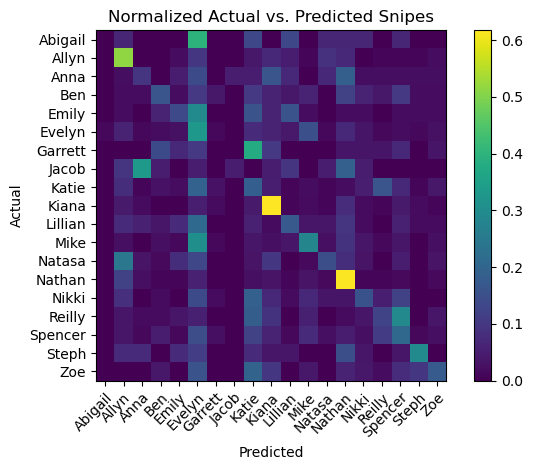

In [ ]:
# Evaluate the loaded model on the test set
confusion_matrix = evaluate_model(vit, test_loader, num_classes)

# Plot the confusion matrix
plot_confusion_matrix(confusion_matrix, label_names)
